In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"  
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dropout,  Input, Layer,Conv1DTranspose
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

from pandas_datareader import data

from PyEMD import EMD,EEMD,CEEMDAN,Visualisation

import warnings
warnings.filterwarnings("ignore")

In [2]:
shares_name='GC=F'

In [3]:
start = '2017-01-01'
end = '2019-01-01'
GSPC = pd.DataFrame(data.DataReader(shares_name,"yahoo",start,end)['Adj Close'])#Choose the data
print(GSPC)
print(GSPC.isnull().sum().sort_values(ascending = False))

GSPC_test = pd.DataFrame(data.DataReader(shares_name,"yahoo",start,end)['Adj Close'])#Choose the data
GSPC_test

              Adj Close
Date                   
2017-01-03  1160.400024
2017-01-04  1163.800049
2017-01-05  1179.699951
2017-01-06  1171.900024
2017-01-09  1183.500000
...                 ...
2018-12-24  1267.500000
2018-12-26  1269.199951
2018-12-27  1277.300049
2018-12-28  1279.900024
2018-12-31  1278.300049

[501 rows x 1 columns]
Adj Close    0
dtype: int64


,Adj Close
Date,
2017-01-03,1160.400024
2017-01-04,1163.800049
2017-01-05,1179.699951
2017-01-06,1171.900024
2017-01-09,1183.500000
...,...
2018-12-24,1267.500000
2018-12-26,1269.199951
2018-12-27,1277.300049


In [4]:
start = '2016-01-01'
end = '2019-01-01'
df=pd.DataFrame(data.DataReader(shares_name,"yahoo",start,end)['Adj Close'])
df = df[['Adj Close']]

In [5]:
def create_noisy(data):
    data_noisy = pd.DataFrame()
    for i in range(0,100):
        data_noisy= pd.concat([data_noisy,pd.Series(data.values[:,0])], axis=1)
    return data_noisy.T

In [6]:
def create_pure(data):
    data_pure = pd.DataFrame()
    for i in range(2,52):
        data_pure['SMA{}'.format(i)] = 0
        data_pure['SMA{}'.format(i)] = data[['Adj Close']].rolling(window=i).mean()
    
    data_pure=data_pure.iloc[:,-len(GSPC_noisy.T):]
    data=data.iloc[-len(GSPC_noisy.T):]
    for i in range(2,52):
        data_pure['EMA{}'.format(i)] = 0
        data_pure['EMA{}'.format(i)] = data[['Adj Close']].ewm(span=i, adjust=False).mean()
    
    return data_pure.T

In [7]:
GSPC_noisy=create_noisy(GSPC)

GSPC_pure=create_pure(df).iloc[:,-len(GSPC_noisy.T):]

In [8]:
mm_t_g = MinMaxScaler()
noise_mm = mm_t_g.fit_transform(GSPC_noisy.T).T
prue_mm=mm_t_g.fit_transform(GSPC_pure.T).T
print(prue_mm.shape)
print(noise_mm.shape)

(100, 501)
(100, 501)


In [9]:
X_train_mm = np.asarray(noise_mm)
X_train_mm=X_train_mm.reshape((len(X_train_mm), len(X_train_mm[0]), 1))
Y_train_mm = np.asarray(prue_mm)
Y_train_mm=Y_train_mm.reshape((len(Y_train_mm), len(Y_train_mm[0]), 1))
X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(X_train_mm, Y_train_mm, test_size=0.2,random_state=1)

In [10]:
keras.backend.clear_session()

In [11]:
def set_model_encoding_mm():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, activation='relu',kernel_constraint=max_norm(2), kernel_initializer='he_uniform',input_shape=(None, 1)))
    model.add(Conv1D(32, kernel_size=3,activation='relu',kernel_constraint=max_norm(2), kernel_initializer='he_uniform'))
    model.add(Conv1DTranspose(32, kernel_size=3, activation='relu',kernel_constraint=max_norm(2), kernel_initializer='he_uniform'))
    model.add(Conv1DTranspose(128, kernel_size=3,activation='relu',kernel_constraint=max_norm(2), kernel_initializer='he_uniform'))
    model.add(Conv1D(1,kernel_size=3,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='binary_crossentropy')
    
    return model
modelen_mm = set_model_encoding_mm()
modelen_mm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         512       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          12320     
                                                                 
 conv1d_transpose (Conv1DTra  (None, None, 32)         3104      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, None, 128)        12416     
 ranspose)                                                       
                                                                 
 conv1d_2 (Conv1D)           (None, None, 1)           385       
                                                                 
Total params: 28,737
Trainable params: 28,737
Non-traina

In [12]:
history_mm = modelen_mm.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=20, batch_size=10, verbose=0)

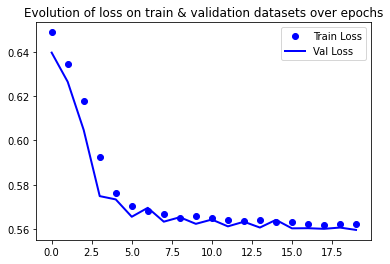

In [13]:
# Check how loss & mae went down
epoch_loss = history_mm.history['loss']
epoch_val_loss = history_mm.history['val_loss']

plt.figure()
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'bo', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'b', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')


plt.show()

1/1 [==============================] - 0s 243ms/step


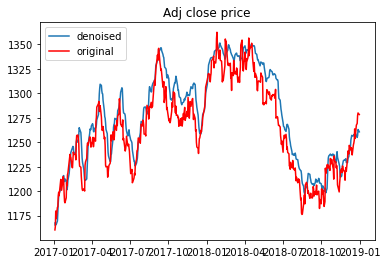

In [14]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((len(GSPC_test),1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
noise_mm_T=pd.DataFrame(noise_mm_T,columns=['Adj Close'],index=GSPC_test.index)
Y_test_mm_cnn=pd.DataFrame(Y_test_mm_cnn,columns=['Adj Close'],index=GSPC_test.index)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn,columns=['Adj Close'],index=GSPC_test.index)
plt.figure()
plt.plot(pure_mm_cnn)
plt.plot(GSPC_test,'r')
plt.title('Adj close price')
plt.legend(['denoised', 'original'], loc='upper left')

# regression

In [15]:
original=GSPC_test
recon=pure_mm_cnn

In [16]:
def features(dataset):
    ret_dataset=pd.DataFrame(index=dataset.index)
    for i in range(2,52,1):
        window = i
        # Volatility
        ret_dataset[str('SMA'+str(i))] = talib.SMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('EMA'+str(i))] = talib.EMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('STDDEV'+str(i))] = talib.STDDEV(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('Lag'+str(i))] = dataset['Adj Close'].shift(i)
    return ret_dataset

In [17]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import talib
splits=10

654.6994478046894
5061.4056134656075
339.00945578143
594.8560917705297
1173.9398101352156
669.7200575985014
424.12980455085636
1245.623002757132
521.2156544629485
286.6726541999727
The last MSE: 286.6726541999727
The average MSE: 1097.1271592526882


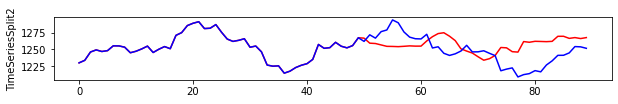

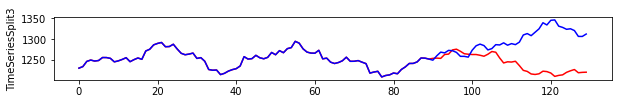

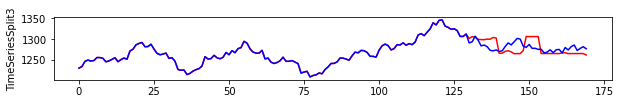

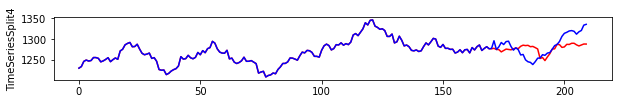

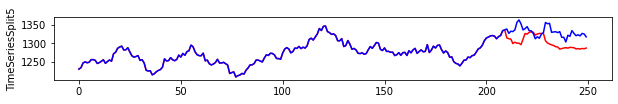

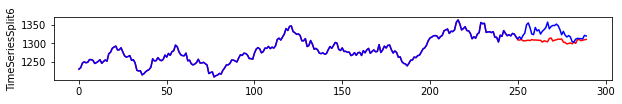

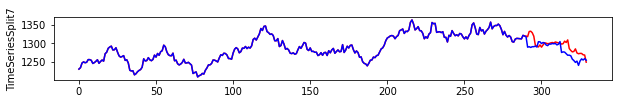

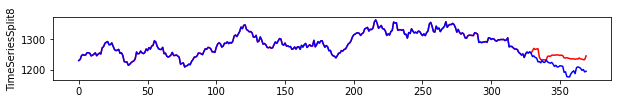

In [ ]:
recon_fea=features(recon)
recon_fea=recon_fea.iloc[51:]
original_m=original.iloc[51::]
recon_m=recon.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0

for train_index, test_index in tscv.split(recon_fea):
    model = xgb.XGBRegressor()
    model.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(recon_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [ ]:
from bayes_opt import BayesianOptimization
def rf_do(max_depth, learning_rate, n_estimators, min_child_weight, subsample, colsample_bytree,reg_alpha,reg_lambda,scale_pos_weight,gamma):
    val = xgb.XGBRegressor(max_depth = round(max_depth),
                           learning_rate = float(learning_rate),
                           n_estimators = round(n_estimators),
                           min_child_weight = round(min_child_weight),
                           #max_delta_step = float(max_delta_step),
                           subsample = float(subsample),
                           colsample_bytree = float(colsample_bytree),
                           reg_alpha = float(reg_alpha),
                           reg_lambda = float(reg_lambda),
                           scale_pos_weight = float(scale_pos_weight),
                           gamma = float(gamma),
                           eval_metric=mean_squared_error)
    msetest=0
    val.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=val.predict(recon_fea.iloc[test_index,:])
    msetest=-1*mean_squared_error(recon_m.iloc[test_index,:],test_predict)
    return msetest

In [20]:
rf_bo = BayesianOptimization(
        rf_do,
                {'max_depth':(1,20),
                'learning_rate': (0.01,0.3),
                'n_estimators': (100,1000),
                'min_child_weight': (0,2),
                #'max_delta_step': (0.01,1),
                'subsample':(0.5,1),
                'colsample_bytree': (0.5,1),
                'reg_alpha': (0.01,1),
                'reg_lambda': (0.2,1),
                'scale_pos_weight': (0.2,1),
                'gamma':(0,1)}
    )
rf_bo.maximize()#init_points=20, n_iter=10
rf_bo_p=rf_bo.max
rf_bo_p['params']['max_depth'] = round(rf_bo_p['params']['max_depth'])
rf_bo_p['params']['n_estimators'] = round(rf_bo_p['params']['n_estimators'])
rf_bo_p['params']['min_child_weight'] = round(rf_bo_p['params']['min_child_weight'])
rf_bo_p

|  15       | -166.6    |  1.0      |  0.0      |  0.01     |  1.0      |  0.0      |  985.9    |  1.0      |  1.0      |  0.2      |  0.5      |
|  16       | -173.3    |  0.6301   |  0.4251   |  0.2731   |  1.171    |  0.8294   |  970.1    |  0.5809   |  0.2472   |  0.802    |  0.5137   |
|  17       | -157.3    |  0.6561   |  0.6283   |  0.06513  |  17.7     |  1.347    |  984.1    |  0.3752   |  0.2038   |  0.6206   |  0.9832   |
|  18       | -128.8    |  1.0      |  1.0      |  0.01     |  13.4     |  2.0      |  955.1    |  0.01     |  0.2      |  1.0      |  1.0      |
|  19       | -115.5    |  0.7269   |  0.1023   |  0.2421   |  19.23    |  0.3798   |  199.7    |  0.5958   |  0.2052   |  0.9546   |  0.6873   |
|  20       | -165.2    |  0.6736   |  0.321    |  0.1791   |  8.412    |  0.2869   |  203.0    |  0.4953   |  0.5625   |  0.5236   |  0.7192   |
|  21       | -219.7    |  0.5      |  1.0      |  0.3      |  20.0     |  2.0      |  188.9    |  1.0      |  0.2      |  1

{'target': -71.3165283203125,
 'params': {'colsample_bytree': 0.5,
  'gamma': 0.0,
  'learning_rate': 0.3,
  'max_depth': 12,
  'min_child_weight': 0,
  'n_estimators': 1000,
  'reg_alpha': 0.01,
  'reg_lambda': 1.0,
  'scale_pos_weight': 0.2,
  'subsample': 0.5}}

312.7165061146021
2427.440056490153
172.3914117436856
204.9500770047307
220.8277773335576
363.1485464449972
107.06323569491505
379.7562545951456
126.71969769708812
97.31922361589969
The last MSE: 97.31922361589969
The average MSE: 441.23327867347746


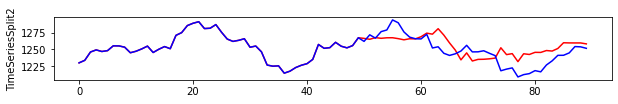

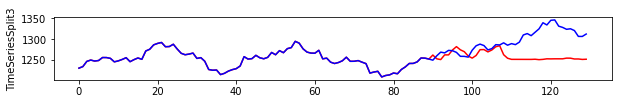

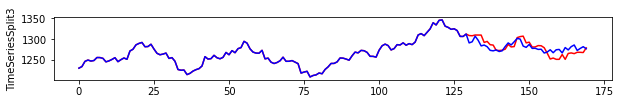

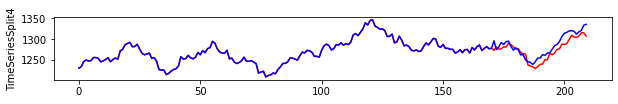

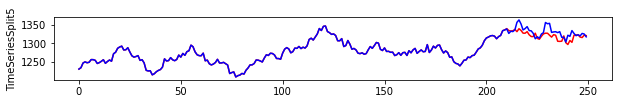

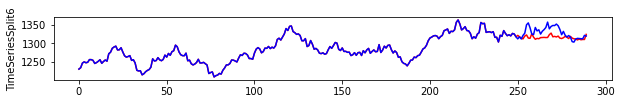

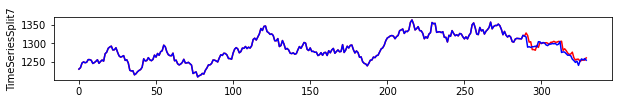

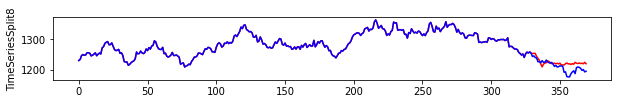

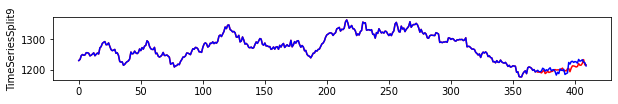

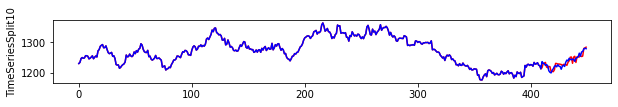

In [21]:
original_fea=features(original)
original_fea=original_fea.iloc[51:]
original_m=original.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(original_fea):
    model = xgb.XGBRegressor()
    model.fit (original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(original_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [22]:
def rf_oo(max_depth, learning_rate, n_estimators, min_child_weight, subsample, colsample_bytree,reg_alpha,reg_lambda,scale_pos_weight,gamma):
    val = xgb.XGBRegressor(max_depth = round(max_depth),
                           learning_rate = float(learning_rate),
                           n_estimators = round(n_estimators),
                           min_child_weight = round(min_child_weight),
                           subsample = float(subsample),
                           colsample_bytree = float(colsample_bytree),
                           reg_alpha = float(reg_alpha),
                           reg_lambda = float(reg_lambda),
                           scale_pos_weight = float(scale_pos_weight),
                           gamma = float(gamma),
                           eval_metric=mean_squared_error)
    msetest=0
    val.fit(original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=val.predict(original_fea.iloc[test_index,:])
    msetest=-1*mean_squared_error(original_m.iloc[test_index,:],test_predict)
    return msetest

In [23]:
rf_bo = BayesianOptimization(
        rf_oo,
                {'max_depth':(1,20),
                'learning_rate': (0.01,0.3),
                'n_estimators': (100,1000),
                'min_child_weight': (0,2),
                'subsample':(0.5,1),
                'colsample_bytree': (0.5,1),
                'reg_alpha': (0.01,1),
                'reg_lambda': (0.2,1),
                'scale_pos_weight': (0.2,1),
                'gamma':(0,1)}
    )
rf_bo.maximize()#init_points=20, n_iter=10
rf_bo_p=rf_bo.max
rf_bo_p['params']['max_depth'] = round(rf_bo_p['params']['max_depth'])
rf_bo_p['params']['n_estimators'] = round(rf_bo_p['params']['n_estimators'])
rf_bo_p['params']['min_child_weight'] = round(rf_bo_p['params']['min_child_weight'])
rf_bo_p

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -74.97    |  0.5285   |  0.4763   |  0.2012   |  14.25    |  1.292    |  867.0    |  0.4955   |  0.485    |  0.4196   |  0.9508   |
|  2        | -108.3    |  0.8244   |  0.1302   |  0.2951   |  12.08    |  0.2005   |  274.7    |  0.3785   |  0.5754   |  0.8576   |  0.9278   |
|  3        | -73.71    |  0.7282   |  0.9195   |  0.1655   |  1.593    |  0.3717   |  158.3    |  0.3556   |  0.6602   |  0.2621   |  0.8132   |
|  4        | -67.09    |  0.9573   |  0.7979   |  0.1704   |  19.58    |  1.1      |  862.6    |  0.9419   |  0.742    |  0.8244   |  0.802    |
|  5        | -82.28    |  0.5505   |  0.2289   |  0.2637   |  1.95     |  0.8528   |  171.4    |  0.1513   |  0.4579   |  0

{'target': -57.73610753044486,
 'params': {'colsample_bytree': 0.6128286411770363,
  'gamma': 0.3681351557002992,
  'learning_rate': 0.09007997879993386,
  'max_depth': 8,
  'min_child_weight': 2,
  'n_estimators': 795,
  'reg_alpha': 0.8207037261619551,
  'reg_lambda': 0.3044110317323556,
  'scale_pos_weight': 0.9671158938739839,
  'subsample': 0.9721709954968422}}

# EMDCNN

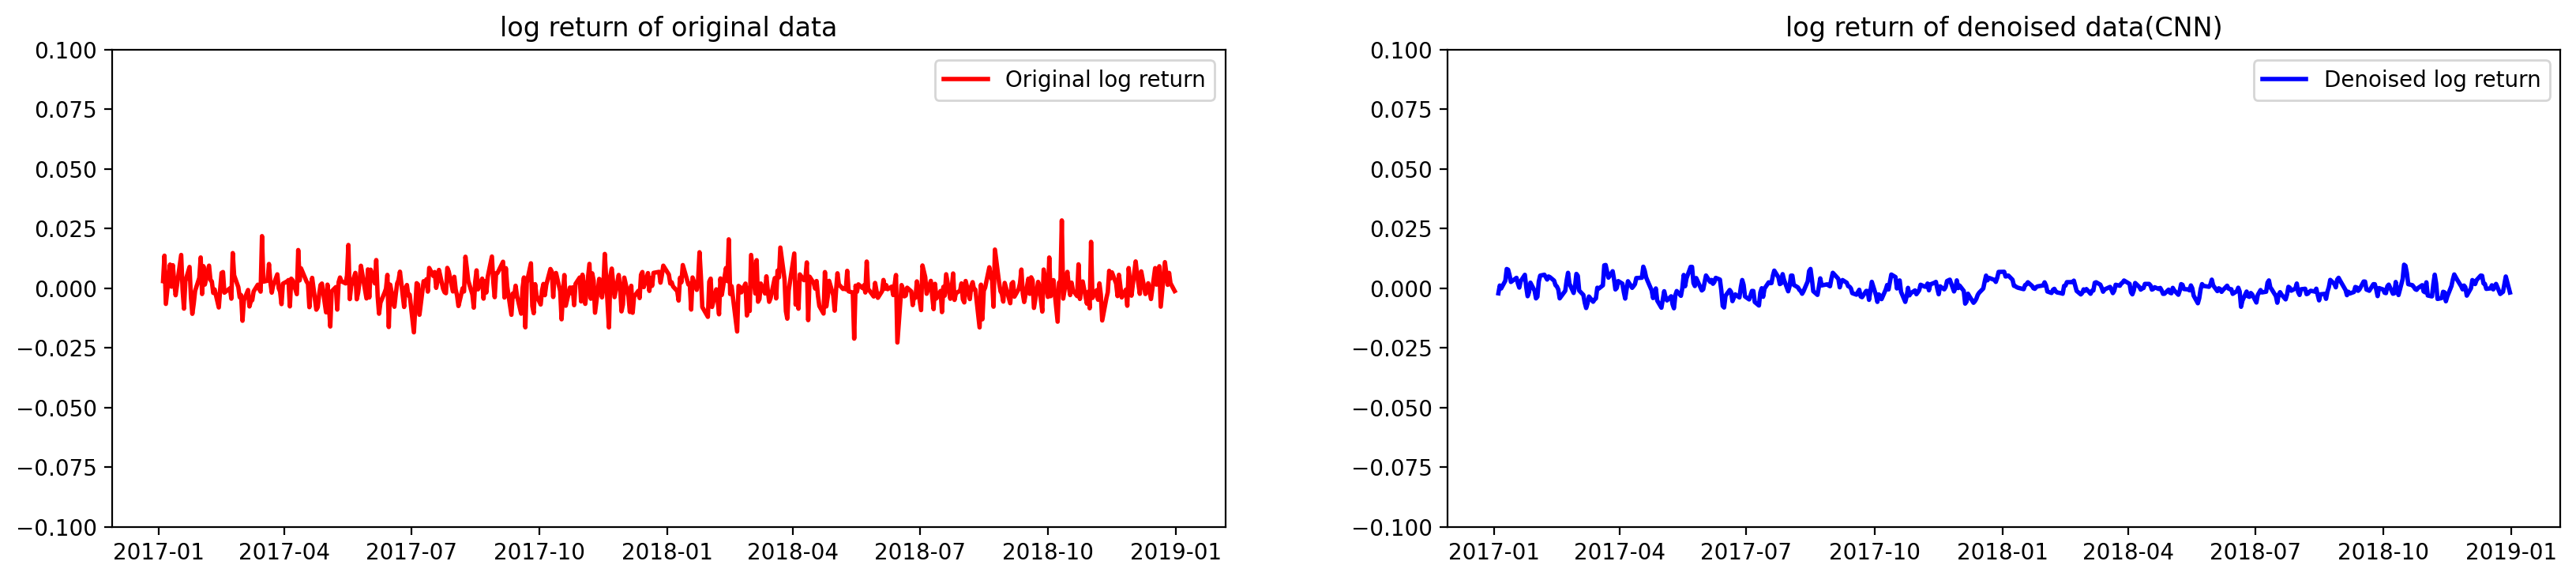

In [24]:
# Log Returns
GSPC_test_n=GSPC_test.copy()
GSPC_test_n['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
pure_mm_cnn['log_ret'] = np.log(pure_mm_cnn.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(GSPC_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.1,0.1)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnn['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.1,0.1)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')


plt.show()

In [25]:
def svmf1_ori(dataset,dataset2,long_predict=10,percentage=0.8):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [26]:
original_svm_ori,denoised_svm_ori=svmf1_ori(GSPC_test_n,pure_mm_cnn,long_predict=1,percentage=1)

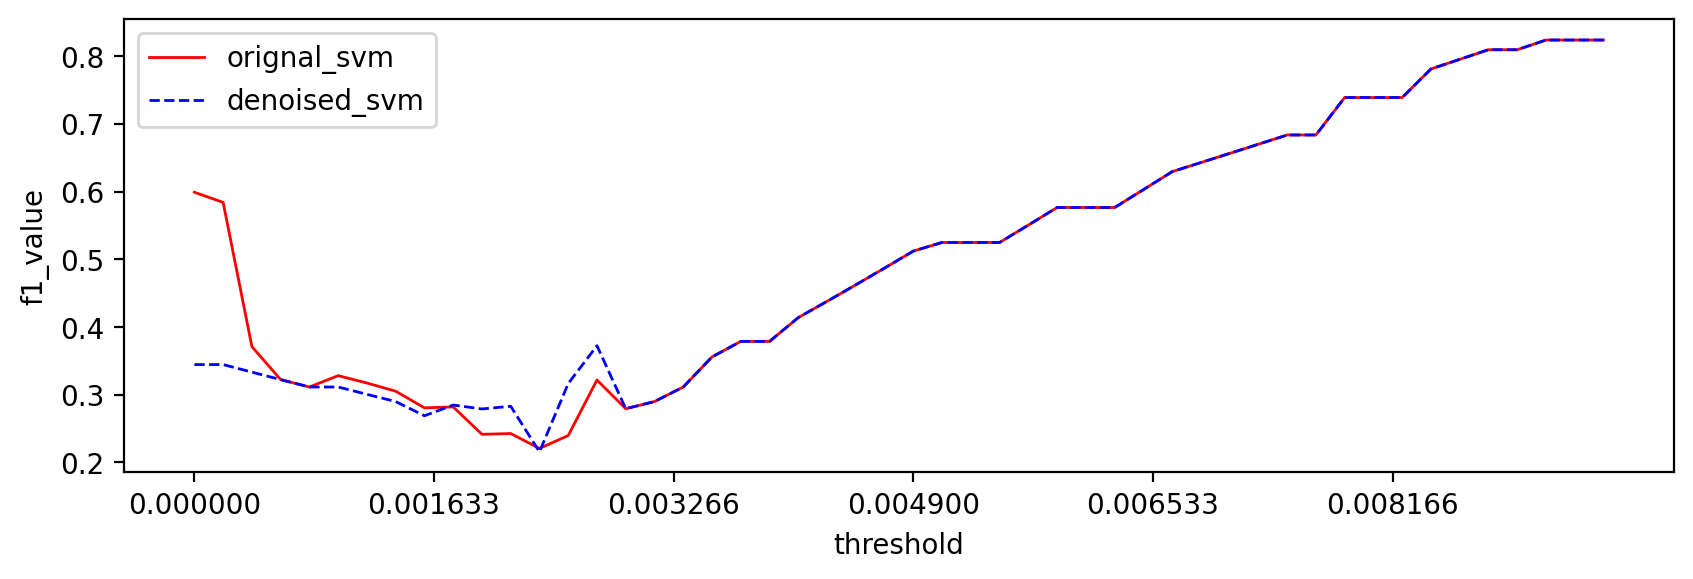

In [27]:
plt.figure(figsize=(10,3),dpi=200)
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),original_svm_ori,label='orignal_svm', color='red', linewidth=1.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=1.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

# Strategies 

## Bollinger band

In [28]:
def bbands(close_prices, window, no_of_stdev):#bollinger  bands, using today's closing price

    rolling_mean = close_prices.rolling(window,min_periods=1).mean()#.shift(1)
    rolling_std = close_prices.rolling(window,min_periods=1).std()#.shift(1)
    

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [29]:
def buy_signal_function(dataset):
    buy_signal=pd.DataFrame(columns=['Price'],index=dataset.index)
    buy_signal['Price']=dataset['Adj Close']
    buy_signal['mean'],buy_signal['upper'],buy_signal['lower']=bbands(dataset['Adj Close'],20,2)
    buy_signal['side'] = np.nan 
    buy_signal['signal'] = np.nan 
    for i in range(0,len(dataset)):
        if (buy_signal.iloc[i,0]<buy_signal.iloc[i,3]):
            buy_signal.iloc[i,4]=1
            if (buy_signal.iloc[i-1,0]>=buy_signal.iloc[i-1,3]):
                buy_signal.iloc[i,5]=1
        elif (buy_signal.iloc[i,0]>buy_signal.iloc[i,2]):
            buy_signal.iloc[i,4]=-1
            if (buy_signal.iloc[i-1,0]<=buy_signal.iloc[i-1,2]):
                buy_signal.iloc[i,5]=-1
    return buy_signal

In [30]:
GSPC_test_signal=buy_signal_function(GSPC_test_n)


pure_mm_cnn_signal=buy_signal_function(pure_mm_cnn)


In [31]:

print('GSPC_test_signal:\n',GSPC_test_signal.signal.value_counts(),'\n')
print('pure_mm_cnn_signal:\n',pure_mm_cnn_signal.signal.value_counts(),'\n')


GSPC_test_signal:
 -1.0    15
 1.0    14
Name: signal, dtype: int64 

pure_mm_cnn_signal:
  1.0    12
-1.0     7
Name: signal, dtype: int64 



In [32]:
print(GSPC_test[GSPC_test_signal.signal == 1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == 1.0])

              Adj Close
Date                   
2017-03-08  1208.500000
2017-05-04  1226.500000
2017-05-09  1214.300049
2017-07-03  1217.900024
2017-07-07  1208.599976
2017-12-05  1261.599976
2017-12-07  1249.800049
2018-05-01  1303.800049
2018-05-15  1288.900024
2018-06-15  1274.599976
2018-07-17  1225.699951
2018-08-13  1191.300049
2018-09-27  1182.300049
2018-11-09  1206.400024
              Adj Close
Date                   
2017-03-13  1202.400024
2017-05-10  1217.300049
2017-12-08  1245.199951
2018-05-01  1303.800049
2018-05-07  1312.199951
2018-05-21  1290.199951
2018-06-21  1267.199951
2018-07-02  1239.800049
2018-08-16  1176.199951
2018-10-03  1198.300049
2018-10-09  1187.199951
2018-11-14  1207.900024


In [33]:
print(GSPC_test[GSPC_test_signal.signal == -1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == -1.0])

              Adj Close
Date                   
2017-02-06  1230.000000
2017-04-12  1275.300049
2017-08-28  1309.699951
2017-09-05  1339.199951
2017-09-07  1345.099976
2017-11-17  1295.800049
2017-12-29  1306.300049
2018-01-24  1355.900024
2018-03-23  1349.300049
2018-10-11  1223.500000
2018-10-15  1226.400024
2018-12-04  1241.099976
2018-12-07  1246.800049
2018-12-20  1263.599976
2018-12-27  1277.300049
              Adj Close
Date                   
2017-02-08  1237.599976
2017-04-19  1281.400024
2017-11-24  1286.699951
2018-01-03  1316.199951
2018-03-29  1322.800049
2018-10-17  1223.699951
2018-12-10  1243.699951


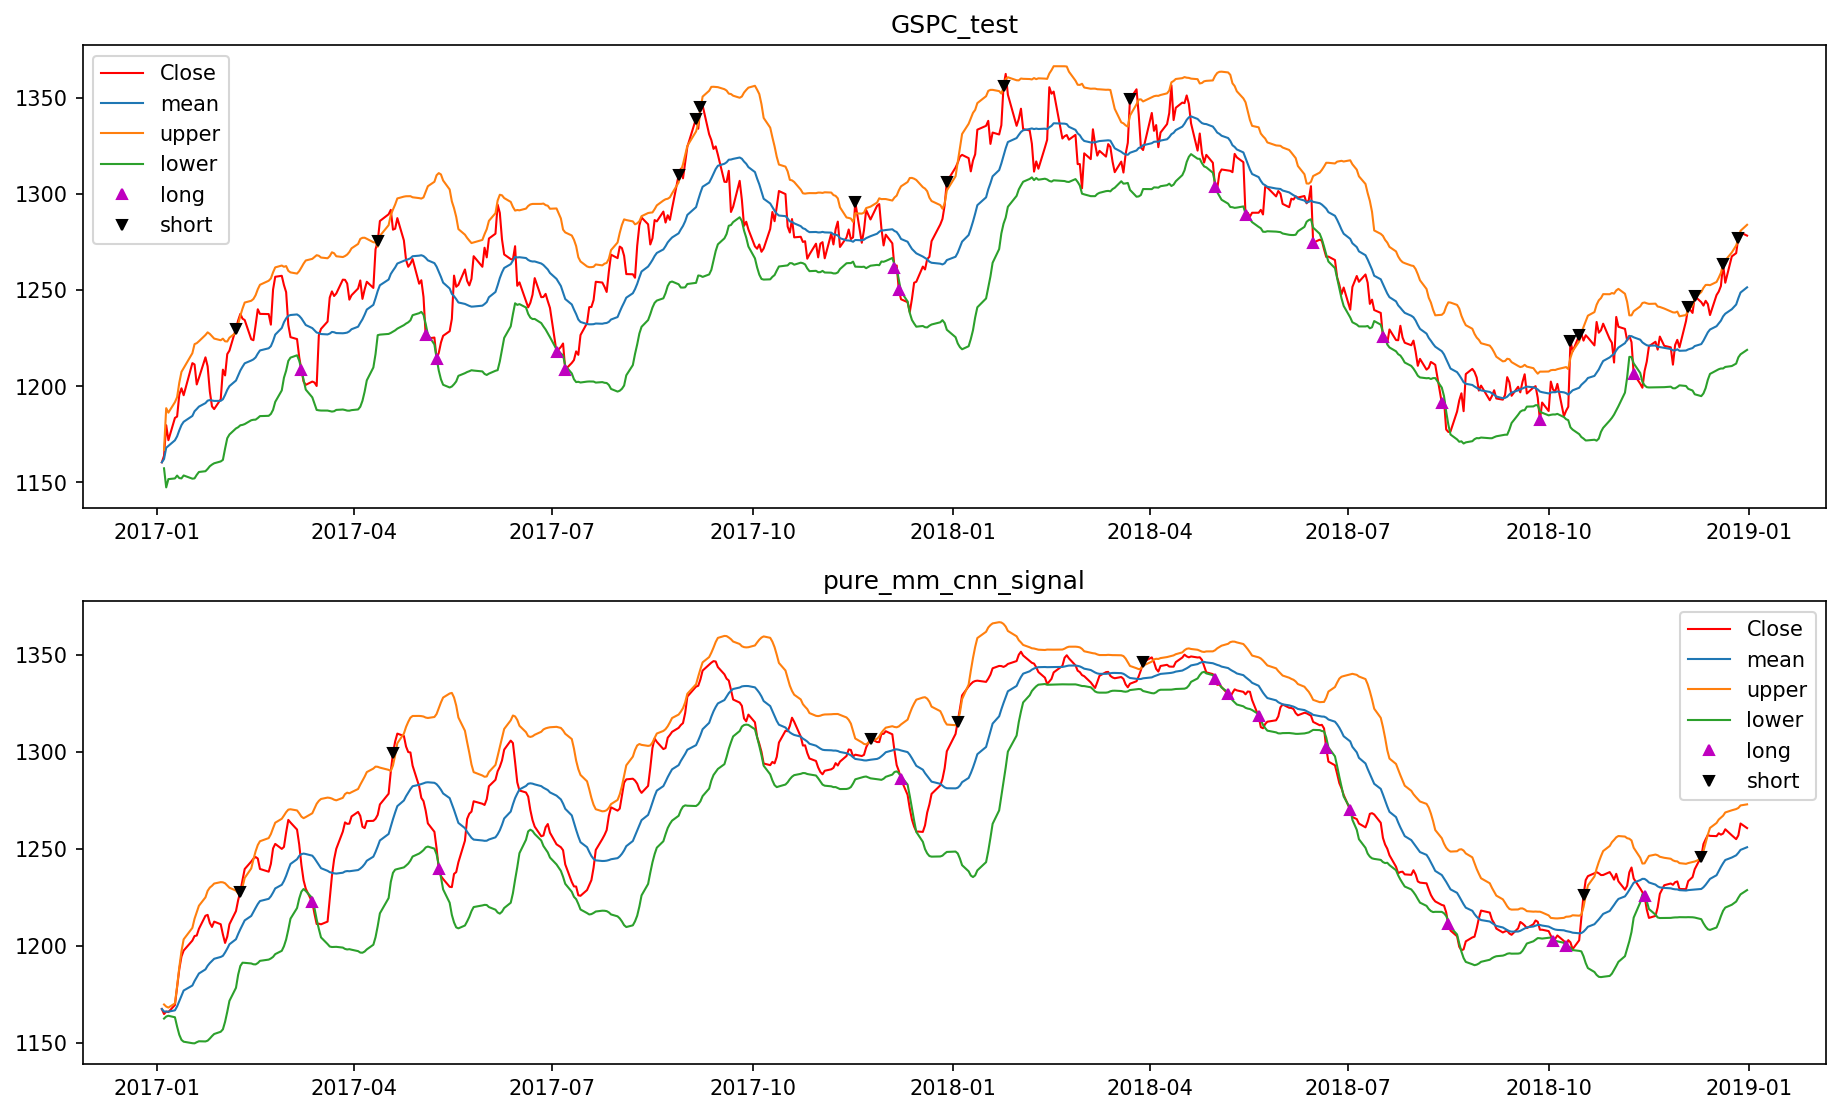

In [34]:
plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_signal['Price'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == -1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn_signal')
plt.plot(pure_mm_cnn_signal['Price'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == 1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == -1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()    


## MACD

In [35]:
def MACD(dataset,short_window = 12,long_window = 26, signal_window=9):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term moving averages
    signals['short_mavg'] = dataset['Adj Close'].ewm(span=short_window, min_periods=1).mean()

    # Calculate long term moving averages
    signals['long_mavg'] = dataset['Adj Close'].ewm(span=long_window, min_periods=1).mean()
    
    # Calculate DIF 
    signals['DIF'] = signals['short_mavg']-signals['long_mavg']
    
     # Calculate DIF moving averages
    signals['DEA'] = signals['DIF'].ewm(span=signal_window, min_periods=1).mean()

    # Generate signal
    signals['signal'] = np.where(signals['DIF']> signals['DEA'], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

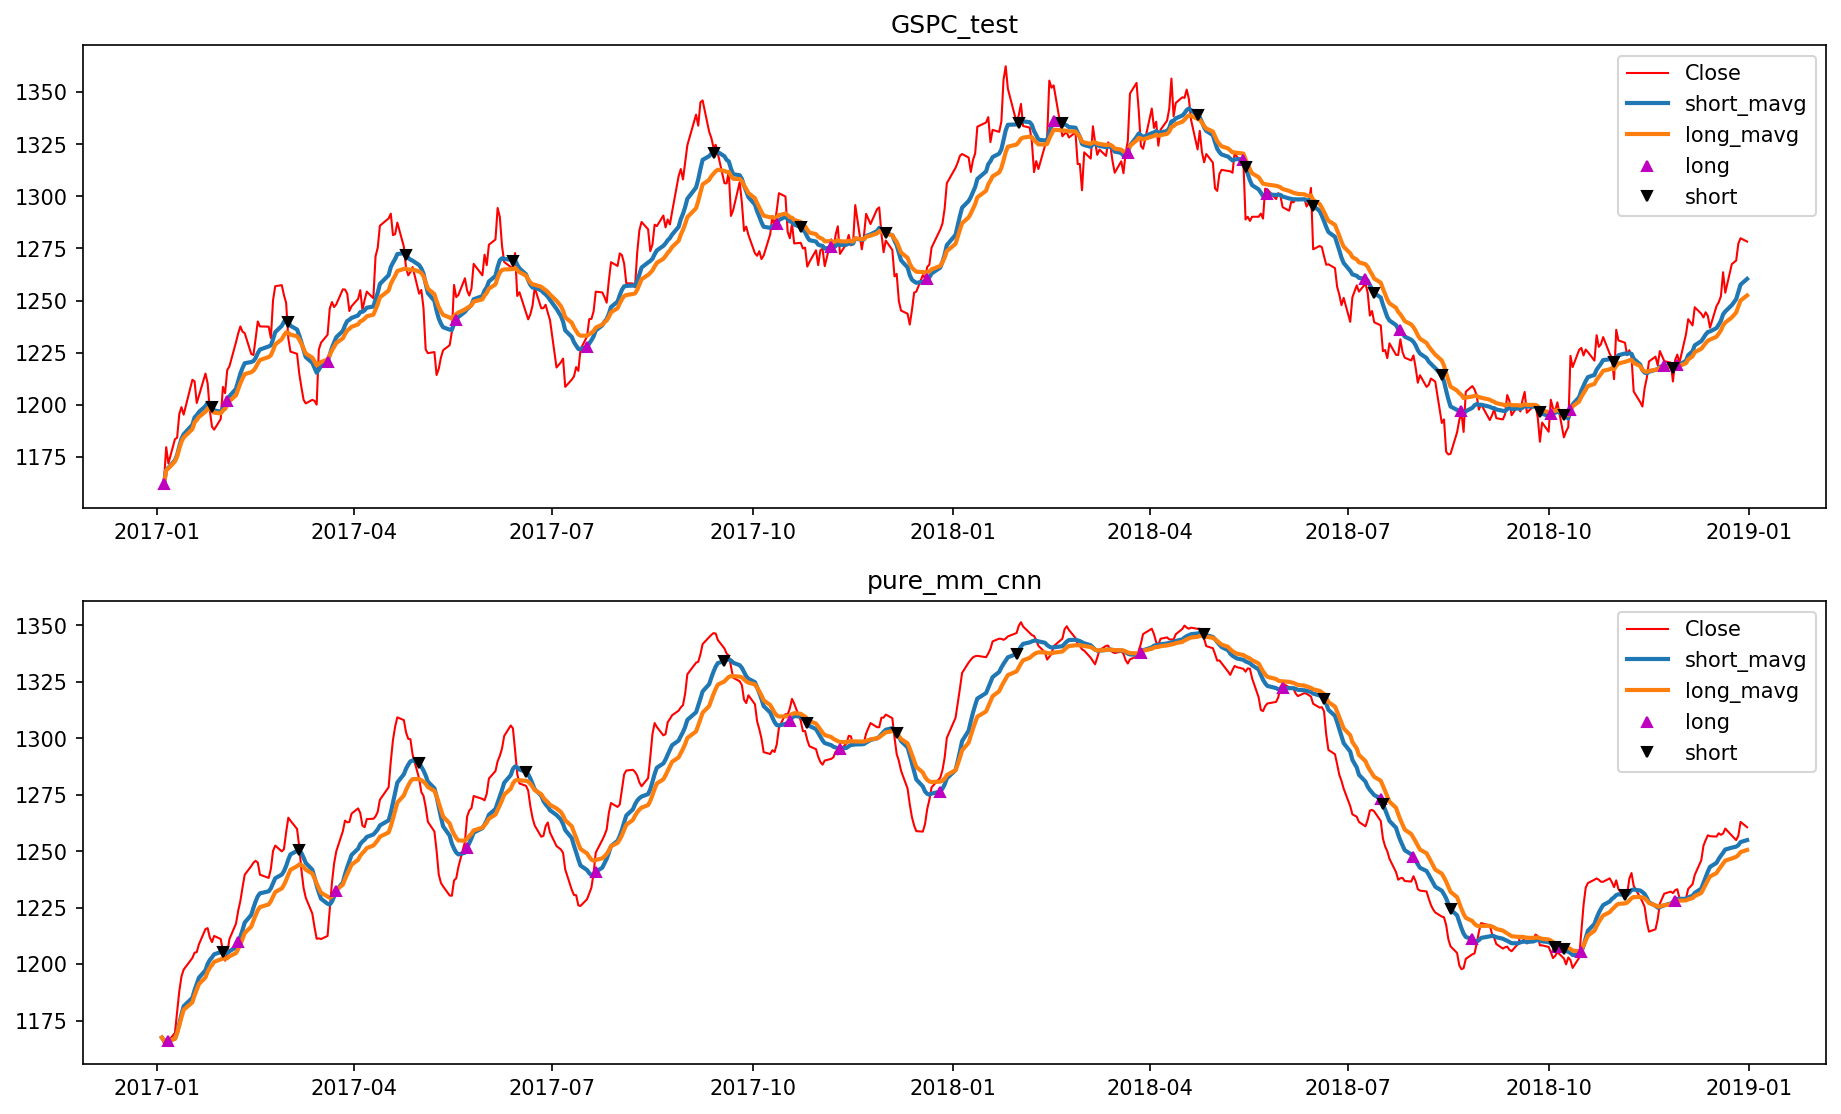

In [36]:
GSPC_test_macd=MACD(GSPC_test_n,short_window = 14,long_window = 22)
pure_mm_cnn_macd=MACD(pure_mm_cnn,short_window = 14,long_window = 22)
#pure_mm_lstm_macd=MACD(pure_mm_lstm,short_window = 14,long_window = 22)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_n['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == 1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == -1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == 1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == -1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [37]:
print('GSPC_test_macd:\n',GSPC_test_macd.positions.value_counts(),'\n')
print('pure_mm_cnn_macd:\n',pure_mm_cnn_macd.positions.value_counts(),'\n')

GSPC_test_macd:
  0.0    463
 1.0     19
-1.0     18
Name: positions, dtype: int64 

pure_mm_cnn_macd:
  0.0    469
 1.0     16
-1.0     15
Name: positions, dtype: int64 



In [38]:
print(GSPC_test[GSPC_test_macd['positions']==1])
print(GSPC_test[pure_mm_cnn_macd['positions']==1])

              Adj Close
Date                   
2017-01-04  1163.800049
2017-02-02  1216.699951
2017-03-20  1233.599976
2017-05-18  1251.699951
2017-07-17  1232.800049
2017-10-12  1293.300049
2017-11-06  1279.400024
2017-12-20  1266.099976
2018-02-16  1353.199951
2018-03-22  1326.599976
2018-05-14  1316.500000
2018-05-25  1303.300049
2018-07-09  1258.099976
2018-07-25  1231.400024
2018-08-22  1196.300049
2018-10-02  1202.400024
2018-10-11  1223.500000
2018-11-23  1221.000000
2018-11-29  1224.099976
              Adj Close
Date                   
2017-01-06  1171.900024
2017-02-07  1234.199951
2017-03-24  1248.199951
2017-05-23  1254.800049
2017-07-21  1254.300049
2017-10-18  1279.900024
2017-11-10  1272.400024
2017-12-26  1284.099976
2018-03-28  1324.199951
2018-06-01  1294.800049
2018-07-16  1238.099976
2018-07-31  1223.699951
2018-08-27  1209.000000
2018-10-05  1201.199951
2018-10-16  1227.300049
2018-11-28  1221.400024


In [39]:
print(GSPC_test[GSPC_test_macd['positions']==-1])
print(GSPC_test[pure_mm_cnn_macd['positions']==-1])

              Adj Close
Date                   
2017-01-26  1189.500000
2017-03-02  1231.900024
2017-04-25  1265.599976
2017-06-13  1265.800049
2017-09-13  1323.400024
2017-10-23  1277.699951
2017-12-01  1278.800049
2018-01-31  1339.000000
2018-02-20  1328.800049
2018-04-23  1322.500000
2018-05-15  1288.900024
2018-06-15  1274.599976
2018-07-13  1239.599976
2018-08-13  1191.300049
2018-09-27  1182.300049
2018-10-08  1184.400024
2018-10-31  1212.300049
2018-11-27  1211.199951
              Adj Close
Date                   
2017-01-31  1208.599976
2017-03-07  1215.099976
2017-05-01  1253.300049
2017-06-19  1244.199951
2017-09-18  1306.300049
2017-10-26  1266.300049
2017-12-06  1262.800049
2018-01-30  1335.400024
2018-04-26  1316.300049
2018-06-20  1271.199951
2018-07-17  1225.699951
2018-08-17  1176.500000
2018-10-04  1197.199951
2018-10-08  1184.400024
2018-11-05  1229.800049


## MA

In [40]:
def MA(dataset,short_window = 10,long_window = 50):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term simple moving averages
    signals['short_mavg'] = dataset['Adj Close'].rolling(window=short_window, min_periods=1).mean()

    # Calculate long term simple moving averages
    signals['long_mavg'] = dataset['Adj Close'].rolling(window=long_window, min_periods=1).mean()

    # Generate signal
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

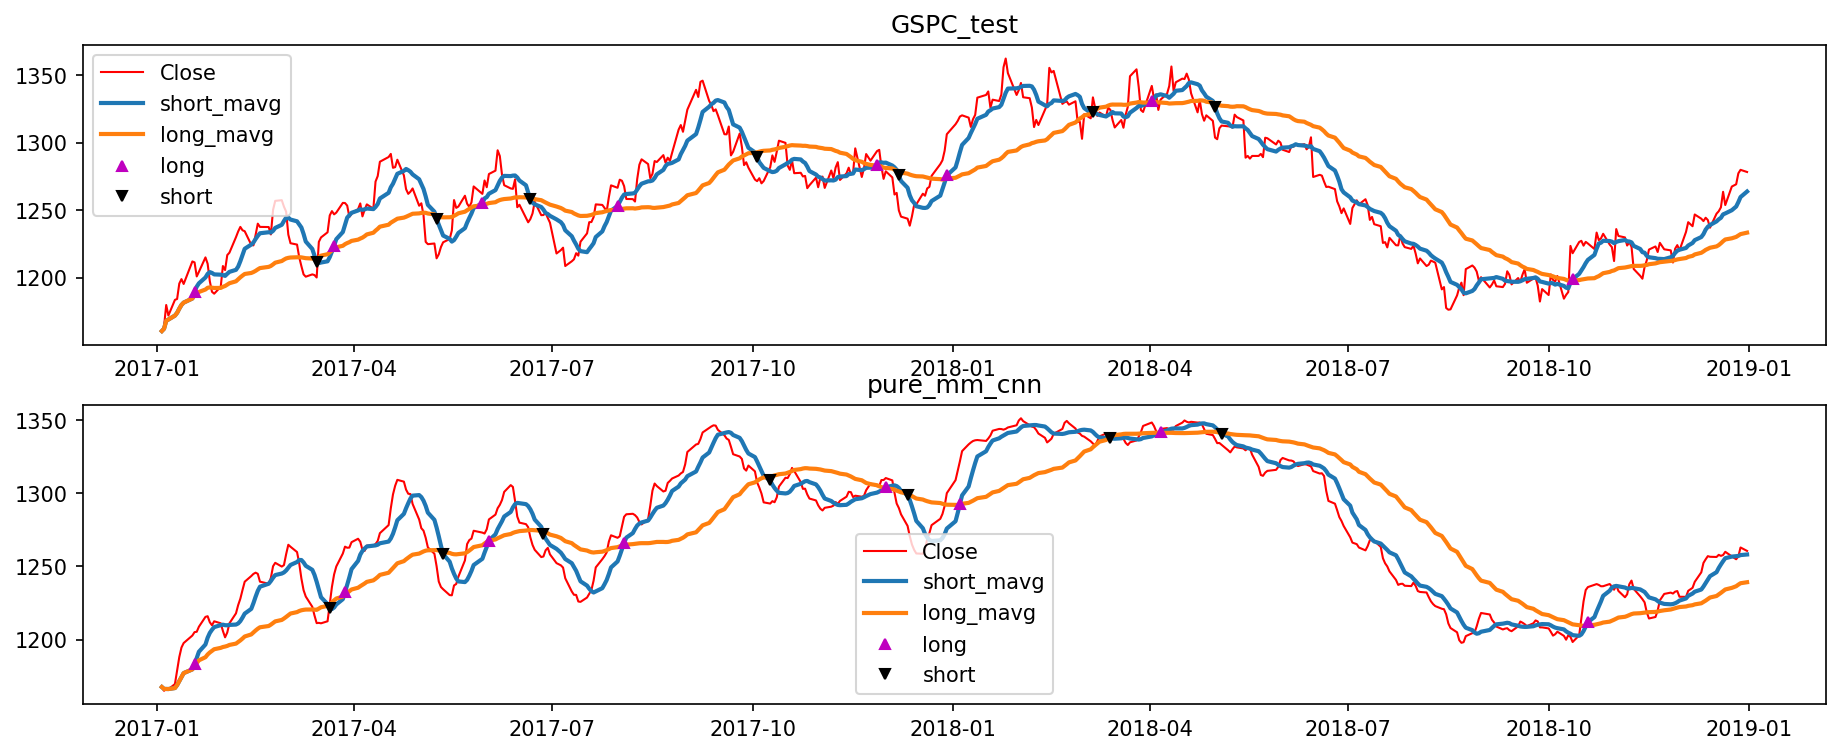

In [41]:
GSPC_test_ma=MA(GSPC_test,short_window = 10,long_window = 50)
pure_mm_cnn_ma=MA(pure_mm_cnn,short_window = 10,long_window = 50)
#pure_mm_lstm_ma=MA(pure_mm_lstm,short_window = 10,long_window = 50)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(3,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == 1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == -1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == 1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == -1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [42]:
print('GSPC_test_ma:\n',GSPC_test_ma.positions.value_counts(),'\n')
print('pure_mm_cnn_ma:\n',pure_mm_cnn_ma.positions.value_counts(),'\n')

GSPC_test_ma:
  0.0    485
 1.0      8
-1.0      7
Name: positions, dtype: int64 

pure_mm_cnn_ma:
  0.0    485
 1.0      8
-1.0      7
Name: positions, dtype: int64 



In [43]:
print(GSPC_test[GSPC_test_ma['positions']==1])
print(GSPC_test[pure_mm_cnn_ma['positions']==1])

              Adj Close
Date                   
2017-01-18  1211.300049
2017-03-23  1246.900024
2017-05-30  1262.099976
2017-07-31  1266.599976
2017-11-27  1293.800049
2017-12-29  1306.300049
2018-04-02  1342.099976
2018-10-12  1218.099976
              Adj Close
Date                   
2017-01-18  1211.300049
2017-03-28  1255.300049
2017-06-02  1276.800049
2017-08-03  1267.800049
2017-12-01  1278.800049
2018-01-04  1319.400024
2018-04-06  1331.900024
2018-10-19  1225.300049


In [44]:
print(GSPC_test[GSPC_test_ma['positions']==-1])
print(GSPC_test[pure_mm_cnn_ma['positions']==-1])

              Adj Close
Date                   
2017-03-15  1200.099976
2017-05-09  1214.300049
2017-06-21  1243.400024
2017-10-03  1271.500000
2017-12-07  1249.800049
2018-03-06  1333.599976
2018-05-01  1303.800049
              Adj Close
Date                   
2017-03-21  1246.099976
2017-05-12  1226.199951
2017-06-27  1246.400024
2017-10-09  1281.800049
2017-12-11  1243.699951
2018-03-14  1324.400024
2018-05-04  1312.699951


## Strategies backtest

In [45]:
def combinesig(dataset,dataset1,dataset2,dataset3):    
    dataset_backtesting=pd.DataFrame()
    dataset_backtesting['Adj Close']=dataset['Adj Close']
    dataset_backtesting['masig']=dataset1['positions']
    dataset_backtesting['macdsig']=dataset2['positions']
    dataset_backtesting['bbsig']=dataset3['signal']
    return dataset_backtesting

In [46]:
GSPC_backtesting=combinesig(GSPC_test,GSPC_test_ma,GSPC_test_macd,GSPC_test_signal)
pure_mm_cnn_backtesting=combinesig(GSPC_test,pure_mm_cnn_ma,pure_mm_cnn_macd,pure_mm_cnn_signal)


In [47]:
def backtest(dataset,asset=1e8, signal=''):
    share_number = 0
    cash = asset
    for i in range(len(dataset)):
        if dataset[signal][i]==1:
            share_number=share_number+cash//(100*dataset['Adj Close'][i])*100
            if cash//(100*dataset['Adj Close'][i])*100>0:
                cash=cash-cash//(100*dataset['Adj Close'][i])*100*dataset['Adj Close'][i]
        elif dataset[signal][i]==-1:
            cash=cash+share_number*dataset['Adj Close'][i]
            share_number=0
    asset_now=cash+share_number*dataset['Adj Close'][i]
    return_value=(asset_now-asset)/asset
    return return_value

In [48]:
mareturn=backtest(GSPC_backtesting,signal='masig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='masig')
print(mareturn)
print(mareturn_cnn)


-0.04061593078613281
-0.0044786884765625


In [49]:
macdreturn=backtest(GSPC_backtesting,signal='macdsig')
macdreturn_cnn=backtest(pure_mm_cnn_backtesting,signal='macdsig')
#mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='macdsig')
print(macdreturn)
print(macdreturn_cnn)
#print(mareturn_lstm)

0.07447558715820313
0.022501717041015626


In [50]:
bbreturn=backtest(GSPC_backtesting,signal='bbsig')
bbreturn_cnn=backtest(pure_mm_cnn_backtesting,signal='bbsig')
print(bbreturn)
print(bbreturn_cnn)


0.12639737585449218
0.15054145764160157
